**Introduction to this project:** 

This project was intended to be presented in April, 2020 at the Rocky Mountain Association of Geologist's Data Science Symposium. Due to COVID-19, this event was postponed. This is a draft of some of the material that would have been presented at this event. I have included the abstract (below) to describe the motivation for this work. Additionally, comments are provided throughout the body of the notebook to guide readers.

While the well log dataset obtained did not end up not as robust as the authors would have liked (as they were limited to freely available LAS files), the results are still consistent overall with expectations. Moverover, the results of this analysis demonstrate the usefullness of introducing more robust analytical methods to a traditionally simple calculation in the oil and gas industry. 



___


**Abstract:**

*Using Python and JupyterLab in the oilfield: how to better understand input parameters for geologic calculations and efficiently assess data relationships.* 

*Geologists in the oil and gas industry are frequently tasked with calculations such as those involved in subsurface mapping, reservoir characterization, or reserves estimates (e.g., pay maps, original hydrocarbons in place, remaining reserves, etc.). A fundamental challenge in these calculations lies in the uncertainty of the inputs, especially as small changes in input values can have a potentially large impact on the result. One way to better understand the range of results that may occur for a given calculation is to decide upon reasonable ranges for all input parameters for the calculation, and then test all possible permutations for the output. Analyses such as this can help elucidate how each input, individually and in combination, affects the result. Further, if a dependent variable is defined, the optimization of input parameters can be explored through a regression analysis. One major challenge to a workflow such as this with “traditional” tools available (e.g., Excel, Petra) is that testing all permutations of input parameters creates a cumbersome and repetitive workload. However, this can be largely alleviated by incorporating tools like Python and JupyterLab, along with some coding knowledge.*

*In this presentation we will use Python and the newly debuted JupyterLab, both of which are free and available to anyone, to walk through an analysis as described above. We will look at a multiple-input reservoir calculation using data such as well logs, producing formation information, and production information. For our calculation, acceptable ranges will be defined for all input parameters and every permutation for the input ranges will be tested using Python. Testing every permutation for the inputs will create a relatively large dataset for the parameter analysis, which we will then visualize and explore in our JupyterLab Notebook. Finally, after defining a dependent variable (e.g., production), we will use linear regression to assess what combination of input parameters is optimal for predicting the dependent variable in our dataset. Ultimately, the goal of this presentation is to share a repeatable workflow that provides a quantitative approach to assessing input ranges for complex geologic calculations.*

___

Broadly speaking, this project can be split up into three phases: 
1. Phase One: Gathering, cleaning, and formatting the data
2. Phase Two: Petrophysical Calculations
3. Phase Three: Analysis

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Phase One: Gathering, cleaning, and formatting the data.
</p><br>

The data for this analysis come from the Wyoming Oil and Gas Conservation Commission. There are four separate types of inputs: digital well logs ("LAS" files), formation tops data, well header data, and production data. The first section of this project focuses on cleaning these data and merging them into a useful dataframe, upon which the petrophysics can be built. 

In [9]:
#Opening Commands and Location of Well Log Files
import numpy as np
import pandas as pd
import re
import os
import fileinput

In [10]:
# HEADER DATAFRAME 
headerOneline=pd.read_csv('C:\\Users\\Allie\\GitHub\\RMAG\\Well Header Data\\120519WellHeader.csv',dtype={0:int}, usecols=[0,17,18])

#GET A 14 DIG API
def find_digits(name):
    x='490'+str(name)
    #x=''.join(re.findall('\d', str(name)))'
    while len(x)<14: 
        x+='0'
    return x
headerOneline['API']=headerOneline['APINO'].map(find_digits)
headerOneline = headerOneline.dropna(how='any')

#Pickle headerOneline: 
headerOneline.to_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\headerOneline.pkl")

# end header dataframe

In [11]:
# PRODUCTION DATAFRAME

#read in production data from WOGCC csv files. Clean API's to correct format, filter to counties of interest, restructure csv
#to have data in column orientation. 

#Additionally, calculate BOE as Oil + Gas/6, as well as 6 and 12 month cum's.

#should just need counties 23, 37,41
Production19_33=pd.read_csv('C:\\Users\\Allie\\GitHub\\RMAG\\Production Data\\Counties19-33_121219.csv',dtype={'APINO':str})
Production35_45=pd.read_csv('C:\\Users\\Allie\\GitHub\\RMAG\\Production Data\\Counties35-45_121219.csv',dtype={'APINO':str})

Production19_45=Production19_33.copy()
allProd=Production19_45.append(Production35_45)

#Get a 14 digit API
def find_digits(name):
    x='490'+str(name)
    #x=''.join(re.findall('\d', str(name)))'
    while len(x)<14: 
        x+='0'
    return x
allProd['API']=allProd['APINO'].map(find_digits)

#Filter to counties 23, 37, or 41
def get_cty(name):
    x=str(name)
    is_cty= ((x.startswith('23')) or (x.startswith('37')) or (x.startswith('41')))
    return is_cty

is_cty=allProd['APINO'].map(get_cty)
Prod3cty=allProd[is_cty]
is_res_frontier =  (Prod3cty.Reservoir.str.contains('frontier|frnr', case=False)) 

KFProduction=Prod3cty[is_res_frontier]
KFProduction   #this should be production just for frontier reservoir and my 3 counties.

headers=list(KFProduction.columns) 

oilHead=['API','YR']
gasHead=['API','YR']
waterHead=['API','YR']
for name in headers:
    x=(str(name))
    if 'OIL' in x:
        oilHead.append(x)
    if 'GAS' in x:
        gasHead.append(x)    
    if 'WATER' in x:
        waterHead.append(x)    

oil=KFProduction[oilHead].copy()
gas=KFProduction[gasHead].copy()
water=KFProduction[waterHead].copy()

oil=pd.melt(oil, id_vars=['API', 'YR'])
gas=pd.melt(gas, id_vars=['API', 'YR'])
water=pd.melt(water, id_vars=['API', 'YR'])

oil['Month']=oil['variable'].map(lambda variable: variable[0:variable.find('_')])    
gas['Month']=gas['variable'].map(lambda variable: variable[0:variable.find('_')])    
water['Month']=water['variable'].map(lambda variable: variable[0:variable.find('_')])    

def month_to_num(month):
    if month=='JAN':
        return 1
    if month=='FEB':
        return 2
    if month=='MAR':
        return 3
    if month=='APR':
        return 4
    if month=='MAY':
        return 5
    if month=='JUN':
        return 6
    if month=='JUL':
        return 7
    if month=='AUG':
        return 8
    if month=='SEP':
        return 9  
    if month=='OCT':
        return 10    
    if month=='NOV':
        return 11        
    if month=='DEC':
        return 12    
        
oil['MonthNum']=oil['Month'].map(month_to_num)
gas['MonthNum']=gas['Month'].map(month_to_num)
water['MonthNum']=water['Month'].map(month_to_num)

oil=oil.rename(columns={'value':'Oil','variable':'monthU'})
gas=gas.rename(columns={'value':'Oil','variable':'monthU'})
water=water.rename(columns={'value':'Oil','variable':'monthU'})

oil.set_index(['API', 'YR','MonthNum'], inplace=True)
gas.set_index(['API', 'YR','MonthNum'], inplace=True)
water.set_index(['API', 'YR','MonthNum'], inplace=True)

oil.sort_index(inplace=True)
gas.sort_index(inplace=True)
water.sort_index(inplace=True)
                                
merge=oil.merge(gas, how='outer', on=['API','YR','MonthNum']).merge(water,how='outer',on=['API','YR','MonthNum'])
merge=merge.rename(columns={'monthU_x':'MONTH_OIL','Oil_x':'Oil','Month_x':'Month','monthU_y':'MONTH_GAS','Oil_y':'Gas','Month_y':'Month','monthU':'MONTH_WATER','Oil':'Water'})

merge=merge.reset_index()
merge['day']=1

merge=merge.rename(columns={'YR': 'year', 'MonthNum': 'month'})

merge['date']=pd.to_datetime(merge[['year', 'month', 'day']])

merge['firstProductionDate'] = merge['date'].where((merge.Oil!=0)|(merge.Gas!=0)).groupby(merge['API']).transform('min')

#calculate BOE
merge['BOE']=merge.Gas/6+merge.Oil


sixMoCondition=(merge.date>=merge.firstProductionDate) & (merge.date<merge.firstProductionDate + pd.offsets.MonthOffset(6))
twelveMoCondition=(merge.date>=merge.firstProductionDate) & (merge.date<merge.firstProductionDate + pd.offsets.MonthOffset(12))
merge['6MoOil']=merge['Oil'].where(sixMoCondition).groupby(merge['API']).transform('sum')
merge['6MoGas']=merge['Gas'].where(sixMoCondition).groupby(merge['API']).transform('sum')
merge['6MoBOE']=merge['BOE'].where(sixMoCondition).groupby(merge['API']).transform('sum')
merge['12MoOil']=merge['Oil'].where(twelveMoCondition).groupby(merge['API']).transform('sum')
merge['12MoGas']=merge['Gas'].where(twelveMoCondition).groupby(merge['API']).transform('sum')
merge['12MoBOE']=merge['BOE'].where(twelveMoCondition).groupby(merge['API']).transform('sum')

merge['CumOil']=merge['Oil'].groupby(merge['API']).transform('sum')
merge['CumGas']=merge['Gas'].groupby(merge['API']).transform('sum')
merge['CumBOE']=merge['BOE'].groupby(merge['API']).transform('sum')


merge.drop(['MONTH_OIL','Month','MONTH_GAS','Month','MONTH_WATER','Month','day'], axis=1, inplace=True)

productionOneline=merge.groupby('API').min()
productionOneline=productionOneline.reset_index()

productionOneline=productionOneline[['API','firstProductionDate','6MoOil','6MoGas','6MoBOE','12MoOil','12MoGas','12MoBOE','CumOil','CumGas','CumBOE']] 
productionOneline = productionOneline.dropna(how='any')

#Pickle productionOneline:
productionOneline.to_pickle('C:\\Users\\Allie\\GitHub\\RMAG\\productionOneline.pkl')

#end production dataframe

In [12]:
#TOPS DATAFRAME

#Read in tops data from WOGCC csv. Fix API formatting, filter to Frontier and Dakota tops of interest. 
#Additionally, if multiple tops are recorded for a certain top for a certain well, take the shallowest one. 
    #E.g., if there are three tops for the Frontier where one represents the main formation top, and the other 
    #two represent picks within the Frontier, take the shallowest (main) top.

FTops=pd.read_csv('C:\\Users\\Allie\\GitHub\\RMAG\\Tops Data\\Tops-StateWide.csv')

def find_digits(name):
    try: 
        x='490'+str(int(float(name)))
        while len(x)<14: 
            x+='0'
    except: 
        return np.NaN
    return x

FTops['API']=FTops['APIu'].map(find_digits)



#Filter to study area
#T 15-23 R 111-113
in_range =  (FTops.Township >=15) & (FTops.Township <=23) & (FTops.Range >=111) & (FTops.Range <=113)
#Study Area Tops
SATops = FTops[in_range]

#FRONTIER TOPS
is_frontier =  (SATops.Formation.str.contains('frontier|frnr', case=False)) 
KFtopsOneline=SATops[is_frontier]

#Turn SATops into a "oneline table" - when multiple depths exist for the Frontier for a well, take the smallest value.
KFtopsOneline=KFtopsOneline.groupby('API', as_index=False).min() 
KFtopsOneline = KFtopsOneline.rename(columns={'Depth': 'FrontierDepth','Formation': 'FrontierTopName'})

KFtopsOneline = KFtopsOneline.dropna(how='any')

#DAKOTA TOPS
is_dakota =  (SATops.Formation.str.contains('dakota', case=False)) 
DAKtopsOneline=SATops[is_dakota]

#Turn SATops into a "oneline table" - when multiple depths exist for the Frontier for a well, take the smallest value.
DAKtopsOneline=DAKtopsOneline.groupby('API', as_index=False).min() 
DAKtopsOneline = DAKtopsOneline.rename(columns={'Depth': 'DakotaDepth','Formation': 'DakotaTopName'})

DAKtopsOneline = DAKtopsOneline.dropna(how='any')

topsOneline=KFtopsOneline.merge(DAKtopsOneline, how='left', on=['API'])

topsOneline=topsOneline[['API', 'Sec_x', 'Township_x','Range_x','Elev_x','FrontierTopName','FrontierDepth', 'DakotaTopName','DakotaDepth']]
topsOneline = topsOneline.rename(columns={'Sec_x': 'Sec','Township_x': 'Township','Range_x': 'Range','Elev_x': 'Elev'})

#Pickle topsOneline:
topsOneline.to_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\topsOneline.pkl")

#end tops dataframe

In [13]:
#LOG DATAFRAME

#This cell will look at all of the LAS files in the LAS folder, read them and get them into a consistent format (things 
#like getting all GR logs to be called GR, rather than GR, GAPI, GRGC, etc.) and then put the resultant clean data into
#a pandas dataframe. Of note, only files which had data for all 6 key logs will be passed to the final dataframe. Thus, 
#while 50-something LAS files were collected for the study area, only 30 will make it into our analysis.

#Alias Definitions
APIAlias=['API', 'UWI', 'Api']
depthAlias=['DEPT','Depth','DEPTH', 'Dept']
grAlias=['GR' , 'GRGC' , 'GAMMA' , 'CGR' , 'GRA' , 'GRDI' , 'GRN' , 'GAM' , 'CGCE' , 'GAPI' , 'GRPI']
dphiAlias=['DPRS', 'DPHI','PORZ' , 'DPOR' , 'PORZD']
nphiAlias=['NPHI','NPRS','NPOR','CNCFD','CNC']
bulkdenAlias=['DEN','RHOB', 'ZDEN','ZDNC']
deepResistivityAlias=['RILD' , 'M2RX' , 'R850' , 'M2R9' , 'RT90' , 'RT60']
#caliperAlias=['CAL', 'CALI','CLDC']
APIlist=[]

def cleaner(filename):
    lines = open(filename, 'r').readlines()
    search = '~A'
    i=0
    idxApi=0
    flag=0
    for i, line in enumerate(lines):
        for item in APIAlias:
            if item in line and idxApi==0:
                idxApi=i
        if search in line:
            break     
        
    #Get API to standardized format of 49012345670000
    API = re.findall('49.*:', lines[idxApi])[0]
    API = ''.join(re.findall('\d',API))
    
    #14 digit API
    while len(API)<14: 
        API+='0'
    
    APIlist.append(API)
    
    #create, open, and then close a textfile that just has column (log) names+well data
    #(i.e. remove header data)
    f = open('text_file.txt', "w+")
    f.write("".join(lines[i:]))
    f.close()

    # Need to get rid of '~A' in the row of column names (otherwise this will shift all columns over by one)
    with open('text_file.txt', 'r') as file :
        filedata = file.read()
    filedata = filedata.replace('~A', ' ')
    with open('text_file.txt', 'w') as file:
        file.write(filedata)
       
    #Read in the csv that we just created: 
    data=pd.read_csv('text_file.txt', delim_whitespace=True)

    #For the aliases defined, go through and determine if some alias for each alias category exists in the current well log.
    #Additionally, replace the dataframe alias name in the current loop with the accepted name (Depth, GR, DEN, DPHI, NPHI, DeepResis)
    #Make sure to "break" after each successful match of an alias to a log, in case there are multiple logs within one file that would match one of the 
        #aliases (e.g., take the first and best match only for each log)
    
    
    # Depth
    depthExist=0
    for item in depthAlias:
        if item in list(data): #if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'Depth'})
            depthExist=1
            break

    # GR
    GRExist=0
    for item in grAlias:
        if item in list(data):  # if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'GR'})
            GRExist = 1
            break
            
    # Bulk Density
    DENExist=0
    for item in bulkdenAlias:
        if item in list(data):  # if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'DEN'})
            DENExist = 1
            break
            
    # Density Porosity
    DPHIExist=0
    for item in dphiAlias:
        if item in list(data):  # if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'DPHI'})
            DPHIExist = 1
            break
            
    # Neutron Porosity
    NPHIExist=0
    for item in nphiAlias:
        if item in list(data):  # if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'NPHI'})
            NPHIExist = 1
            break
            
    # Deep Resistivity
    RILDExist=0
    for item in deepResistivityAlias:
        if item in list(data):  # if the item is in the list of column headers for dataframe "data"
            data = data.rename(columns={item: 'DeepResis'})
            RILDExist = 1
            break

    #Only pass log data to the final log dataframe it it had all of the logs of interest: 
    if ((depthExist==1) & (GRExist==1) & (RILDExist==1) & (DPHIExist==1) & (NPHIExist==1) & (DENExist==1)):  
        data['API'] = API
        return data[['Depth','API','GR', 'DEN','DPHI','NPHI', 'DeepResis']]
    
    
#Call log function
path='C:\\Users\\Allie\\GitHub\\RMAG\\LAS Data\\'

dfLogs=pd.DataFrame()

for filename in os.listdir(path):
    dfLogs=dfLogs.append(cleaner(path+filename))

    
#Pickle dfLogs:
dfLogs.to_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\dfLogs.pkl")

#end logs

In [14]:
# JOIN ALL DATAFRAMES

#Merge: headerOneline and productionOneline and topsOneline
dfOneline=productionOneline.merge(topsOneline, how='inner', on=['API']).merge(headerOneline,how='inner',on=['API'])
del dfOneline['APINO']


#Merge dfOneline with dfLogs
df=dfLogs.merge(dfOneline, how='inner', on=['API'])

In [15]:
#CLEANING DF

#This cell does some final house-keeping for our new dataframe. Issues are described below.

pd.set_option('display.max_columns',400) #should only need ~24

#Some porosities are fractional, some aren't. To Fix: 
df['DPHI'] = np.where(df.DPHI>1,(df.DPHI/100),df.DPHI)
df['NPHI'] = np.where(df.NPHI>1,(df.NPHI/100),df.NPHI)

#DPHI and NPHI between 0 and 1
#DEN and GR not negative
#RILD between 0 and 10000
df.GR=df.GR.mask(df.GR.lt(0),np.nan)
df.DEN=df.DEN.mask(df.DEN.lt(0),np.nan)
df.NPHI=df.NPHI.mask(df.NPHI.lt(0)|df.NPHI.gt(1),np.nan)
df.DPHI=df.DPHI.mask(df.DPHI.lt(0)|df.DPHI.gt(1),np.nan)
df.DeepResis=df.DeepResis.mask(df.DeepResis.lt(0),np.nan)



#Some tops aren't where I want: 
# 49023222800000 - top at 10350, want to move to 11153
# 49023222790000 - top at 10350, want to move to 11122
# 49023224510000 - top at 11030, want to move to 10946
# 49041214460000 - top at 11961, want to move to 11930
# 49023224520000 - top at 10834, want to move to 10800
df.loc[df.API == '49023222800000', 'FrontierDepth'] = 11153
df.loc[df.API == '49023222790000', 'FrontierDepth'] = 11122
df.loc[df.API == '49023224510000', 'FrontierDepth'] = 10946
df.loc[df.API == '49041214460000', 'FrontierDepth'] = 11930
df.loc[df.API == '49023224520000', 'FrontierDepth'] = 10800


#Delete this well as it is missing GR over KF
# 49037288650000 - double checked raw LAS from WOGCC, indeed does not cover KF
df = df[df['API'] != '49037288650000']

#end cleaning df

In [16]:
# FIND FRONTIER BASE AND GET FRONTIER THICKNESS

#Frontier Tops, Bottom, and Res Thickness
#Get deepest GR values. Note ~ reverses the logic, so that we find the deepest non-null GR per well and take its depth
df['DeepestGR'] = df['Depth'].where(~np.isnan(df.GR)).groupby(df['API']).transform('max')

#Take the smaller of the two: KF Top plus 300 OR deepest GR
df['FrontierBase'] = np.where((df.DeepestGR>(df.FrontierDepth+300)), df.FrontierDepth+300, df.DeepestGR)
df.loc[df.API == '49037274080000', 'FrontierBase'] = 12169

#Get reservoir thickness: 
df['KFThicknses']=df.FrontierBase-df.FrontierDepth

In [17]:
#Pickle df:
df.to_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\df.pkl")

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Phase Two: Petrophysics
</p><br>

At this stage in the project, all four of the input types (well log files, well header information, tops information, and production data have been appropriately formatted and merged into one Pandas Dataframe. 

From here, we will look at adding the appropriate petrophysical calculations to our well log data. 

In [32]:
#Set this cell up so that, if data prep has already been completed and dataframes have been pickedl, you can pick up here 
#without re-running data cleaning steps.

import pandas as pd
import numpy as np

pd.set_option('display.max_columns',100) 
df = pd.read_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\df.pkl")

In [33]:
df

,Depth,API,GR,DEN,DPHI,NPHI,DeepResis,firstProductionDate,6MoOil,6MoGas,6MoBOE,12MoOil,12MoGas,12MoBOE,CumOil,CumGas,CumBOE,Sec,Township,Range,Elev,FrontierTopName,FrontierDepth,DakotaTopName,DakotaDepth,LON,LAT,DeepestGR,FrontierBase,KFThicknses
0,100.0,49023222790000,51.338,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0
1,100.5,49023222790000,56.067,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0
2,101.0,49023222790000,59.779,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0
3,101.5,49023222790000,57.598,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0
4,102.0,49023222790000,52.273,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717326,12754.0,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0
717327,12754.5,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0
717328,12755.0,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0
717329,12755.5,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0


Notes: 
- Sw: 
    - Began trying to use Archies clean sand
        - This produced poor results, (e.g., values commonly >100%), despite running it with different varieties of PHI calculations
    - Tried Sw Simandoux, but settled on Sw Indonesia, which is better suited for not entirely clean sands
- POR: 
    - Initially ran on model from Dave's email (where RHOB=2.69 and RHOF=1 when DPHI<NPHI, else RHOF=0.517 for gas)
    - While this was a great improvement off of just using PHIe=DPHI with no modifications, it did lead to odd and unnatural "spikes" at boundaries where NPHI and DPHI flipped in terms of which was larger
    - Settled on a method from Crain's Petrophysical Handbook - discussed in more detail in the Porosity section below
- Also ended up adding in a Vsh component and conducing a "stretch/squeeze" normalization on gamma ray



Inputs: 
In addition to the log curves, there were 7 parameters needed. Some are for the whole field, some are values needed for each well. 

Whole Field: 
1. Clean Sand GR - for normalization. What is one value that best represents clean sand for the whole study area? 
2. Shale GR - for normalization. Same as above but for shale. 
3. Neutron Porosity value for shale for study area.
4. Density Porosity value for shale for study area.

Each well needs a: 


5. Clean Sand GR value
6. Shale GR value
7. Resistivity of Shale value


In [34]:
### OBTAINING THE 7 VALUES

# 1 & 2: GR values for entire field clean sand and shale
cleanSandGR=30
shaleGR = 110

# 3 & 4 : DPHI SHALE AND NPHI SHALE
DPHIsh=0.04 #maybe even only 3%?
NPHIsh=0.2 #Potentially as low as 18%... definitely 18-20%

#For 5 & 6: define the intervals to pull values from: 
df['PetZone']= (df['Depth'] > df['FrontierDepth']-400) & (df['Depth'] < df['FrontierBase']) 
df['ResFlag']= (df['Depth'] > df['FrontierDepth']) & (df['Depth'] < df['FrontierBase']) 


# 5 & 6: GR values for each well's clean sand and shale
#Experimented with P05/95 and P01/99 - settled on min/max... open to discussion.
df['cleanSandGR'] = df['GR'].where(df.ResFlag==True).groupby(df['API']).transform('min')
df['shaleGR'] = df['GR'].where(df.PetZone==True).groupby(df['API']).transform('max')

# 7: Rt of Shale for each well:
df['ShaleRt']=df['DeepResis'].where(((df.Depth < df.FrontierDepth-50) & (df.Depth>df.FrontierDepth-400))).groupby(df['API']).transform('mean')
# not including the first 50' above the Top of Frontier due to top pick issues and this including some thin sand beds in some of the wells.

Normalized Gamma Ray

\begin{equation*}
GR_{norm}   = GR_{min} + \left( \frac{{(GR_{max}-GR_{min})}*{(GR-GR_{low})}}{GR_{high}-GR_{low}} \right)
\end{equation*}

Where:
- $GR_{norm}$ = Normalized GR
- $GR$ = Raw GR log
- $GR_{max}$ = Max GR - Shale value for entire field
- $GR_{min}$ = Min GR - Clean Sand value for entire field
- $GR_{high}$ = Shale GR value for well
- $GR_{low}$ = Clean Sand GR value for well


In [35]:
#GRnorm

df['GRnorm']=(cleanSandGR+(shaleGR-cleanSandGR)*((df.GR-df.cleanSandGR)/(df.shaleGR-df.cleanSandGR)))

# df[df['GRnorm']<0]
# df.groupby('API').GRnorm.min()

Vsh

\begin{equation*}
V_{sh}   = \left( \frac{GR_{norm}-GR_{min}}{GR_{max}-GR_{min}} \right)
\end{equation*}

Where:
- $V_{sh}$ = Shale Volume
- $GR_{norm}$ = Normalized GR
- $GR_{max}$ = Max GR - Shale value for entire field
- $GR_{min}$ = Min GR - Clean Sand value for entire field

In [36]:
#Vsh
df['Vsh']=(df.GRnorm-cleanSandGR)/(shaleGR-cleanSandGR)
df.Vsh=df.Vsh.mask(df.Vsh.lt(0),0) #There are no negative values within the Frontier Zone

Effective Porosity

\begin{equation*}
PHI_{dc}   = DPHI-V_{sh}* DPHI_{sh}
\end{equation*}
\begin{equation*}
PHI_{nc}   = NPHI-V_{sh}* NPHI_{sh}
\end{equation*}

_When:_
$PHI_{nc}$>$PHI_{dc}$

\begin{equation*}
PHI_{e}   = \left( \frac{PHI_{nc} + PHI_{dc}}{2} \right)
\end{equation*}


_When:_
$PHI_{dc}$>$PHI_{nc}$

\begin{equation*}
PHI_{e}   = \left( \frac{PHI_{nc}^2 + PHI_{dc}^2}{2} \right)^{\!1/2}
\end{equation*}



Where:
- $PHI_{e}$ = Effective Porosity
- $DPHI$ = Raw Density Porosity Log
- $NPHI$ = Raw Neutron Porosity Log
- $DPHI_{sh}$ = Study-wide value for DPHI in shale
- $NPHI_{sh}$ = Study-wide value for NPHI in shale
- $PHI_{dc}$ = Vsh Corrected Density Porosity
- $PHI_{nc}$ = Vsh Corrected Neutron Porosity
- $V_{sh}$ = Shale Volume


In [37]:
#PHIe

df['DPHIc']=df['DPHI']-df.Vsh*DPHIsh
df['NPHIc']=df['NPHI']-df.Vsh*NPHIsh

#if den>neutron: crossover
df['PHIe']=(df.PetZone==True)*(np.where(df.DPHIc>df.NPHIc,(((df.DPHIc**2)+(df.NPHIc**2))/2)**(1/2),(df.DPHIc+df.NPHIc)/2))

# df.groupby('API').PHIe.mean()
# df[df['PHIe']>1]

Getting Rw for Water Saturation

Based on TDS Equivalent calculations from 2 wells in the dataset and at-a-glance checks with other wells in the area.
049-037-26787 TDS: 4799, NaCl Equivalent N/A. CALCULATED NACL EQUIVALENT: 4,629. Calculated FM Temp = 203. => Rw = 0.33. 

049-041-21326 TDS: 4553, NaCl Equivalent N/A. CALCULATED NACL EQUIVALENT: 4,052. Calculated FM Temp = 223 => Rw = 0.30.

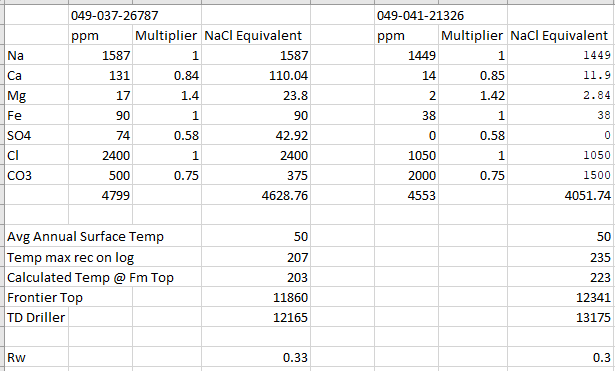

Water Saturation Indonesia



\begin{equation*}
S_w   = \left( \frac{\sqrt{\frac{1}{R_t}} }{\frac{V_{sh}^{1-0.5V_{sh}}}{\sqrt{R_{sh}}}   +  \sqrt{ \frac{PHI_{e}^m}{a*R_{w}}       }       } \right)^{\!2/n}
\end{equation*}

Where:
- $S_w$ = Water Waturation
- $R_w$ = Resistivity of formation water. We are using 0.3.
- $R_t$ = Actual formation resistivity 
- $V_{sh}$ = Shale Volume
- $PHI_{e}$ = Effective Porosity
- $R_{sh}$ = Resistivity of Shale
- $a$ = Constant, generally taken to be 1
- $m$ = Constant, generally taken to be 2. We are using 1.8.
- $n$ = Constant, generally taken to be 2

In [38]:
#SwInd

Rw=0.3
m=1.8
 
df['SwInd']= (df.PetZone==True)*(((1/df.DeepResis)**(1/2))/(((df.Vsh**(1-0.5*df.Vsh))/(df.ShaleRt**(1/2))) + (((df.PHIe**m)/Rw)**(1/2))))
#Nothing above 1 or below 0 with no corrections! 
df[df['SwInd']>1]
df.SwInd=df.SwInd.mask(df.SwInd.gt(1),1)
#df.groupby('API').SwInd.mean()

In [39]:
#Save data frame with Petrophysics
df.to_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\dfWithPetrophysics.pkl")

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Phase Three: Analysis.
</p><br>

In [40]:
#Can start from here with "res" dataframe to skip the datacleaning and petrophysical calculations if desired.
import pandas as pd
import numpy as np
res=pd.read_pickle("C:\\Users\\Allie\\GitHub\\RMAG\\dfWithPetrophysics.pkl")

In [41]:
res

,Depth,API,GR,DEN,DPHI,NPHI,DeepResis,firstProductionDate,6MoOil,6MoGas,6MoBOE,12MoOil,12MoGas,12MoBOE,CumOil,CumGas,CumBOE,Sec,Township,Range,Elev,FrontierTopName,FrontierDepth,DakotaTopName,DakotaDepth,LON,LAT,DeepestGR,FrontierBase,KFThicknses,PetZone,ResFlag,cleanSandGR,shaleGR,ShaleRt,GRnorm,Vsh,DPHIc,NPHIc,PHIe,SwInd
0,100.0,49023222790000,51.338,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,False,False,39.039,180.657,6.704494,36.947704,0.086846,NaN,NaN,NaN,NaN
1,100.5,49023222790000,56.067,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,False,False,39.039,180.657,6.704494,39.619116,0.120239,NaN,NaN,NaN,NaN
2,101.0,49023222790000,59.779,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,False,False,39.039,180.657,6.704494,41.716025,0.146450,NaN,NaN,NaN,NaN
3,101.5,49023222790000,57.598,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,False,False,39.039,180.657,6.704494,40.483978,0.131050,NaN,NaN,NaN,NaN
4,102.0,49023222790000,52.273,NaN,NaN,NaN,NaN,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,False,False,39.039,180.657,6.704494,37.475886,0.093449,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717326,12754.0,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,False,False,27.851,228.432,7.421817,NaN,NaN,NaN,NaN,NaN,NaN
717327,12754.5,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,False,False,27.851,228.432,7.421817,NaN,NaN,NaN,NaN,NaN,NaN
717328,12755.0,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,False,False,27.851,228.432,7.421817,NaN,NaN,NaN,NaN,NaN,NaN
717329,12755.5,49041214610000,NaN,NaN,NaN,NaN,NaN,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,False,False,27.851,228.432,7.421817,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#No longer need rows outside of Frontier zone: 
res = res[(res['Depth'] > res['FrontierDepth']) & (res['Depth'] < res['FrontierBase'])] 

In [43]:
#Three plots to look at cum, 12, and 6 month BOE per well
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
from bokeh.layouts import gridplot

ol = res.groupby('API').max().reset_index()
ol['firstProdYear']=ol['firstProductionDate'].dt.year
#ol=ol[['API','firstProductionDate','firstProdYear','CumBOE','12MoBOE','6MoBOE']]

# ol = ol.sort_values('firstProductionDate', ascending=True)
ol['firstProdYear']=ol['firstProductionDate'].dt.year


# Define x and y axes for the three plots
x=ol.firstProdYear
y1=ol.CumBOE
y2=ol['12MoBOE']
y3=ol['6MoBOE']

#p = figure(x_axis_type='datetime')
production = figure()
plot_options = dict(width=250, plot_height=250, tools='pan,wheel_zoom')

# create a new plot
s1 = figure(**plot_options, title='CumBOE')
s1.circle(x, y1, size=10, color="navy")

# create a new plot 
s2 = figure(x_range=s1.x_range, **plot_options,title='12MoBOE')
s2.triangle(x, y2, size=10, color="firebrick")

# create a new plot
s3 = figure(x_range=s1.x_range,**plot_options,title='6MoBOE')
s3.square(x, y3, size=10, color="olive")

s1.xaxis.axis_label = "Year of First Production"
s2.xaxis.axis_label = "Year of First Production"
s3.xaxis.axis_label = "Year of First Production"
s1.yaxis.axis_label = "BOE"

production = gridplot([[s1, s2, s3]])

show(production)

Loading BokehJS ...

Figure above. Production by year of first recorded production
- cum BOE is just total sum
    - Calculated with oil+gas/6
- 6 and 12 month BOE is the sum of production over 6 and 12 months, respectively, starting at the month of first recorded (non-zero) production for EITHER oil or gas
 - Future work includes updating to start counting production once it has "cleaned up."
- Also notice the charts are interactive! You can pan around and zoom in.

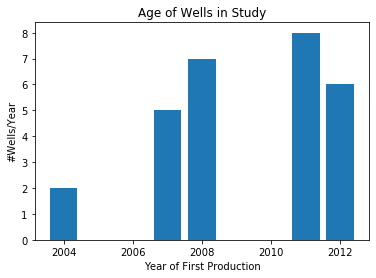

In [44]:
# Show wells spud* per year
#*technically just using year of first recorded production...

x=ol.groupby('firstProdYear').API.count().reset_index()

import matplotlib.pyplot as plt
plt.xlabel('Year of First Production')
plt.ylabel('#Wells/Year')
plt.title('Age of Wells in Study')
z=plt.bar(x.firstProdYear, x.API)

Figure above. Number of wells by year in dataset. Year used is the year in which first recorded production for either oil or gas was reported.
- This is NOT a representative sample of wells in this field - these are all quite young.
- I'll have to find a citation for this, but I think most wells in this field are...... 70s-80s
- This is a very recent sliver of all Frontier gas wells in this area
- The bias, I assume, is because I searched only for freely available (WOGCC) digital well logs for the area. I think the free LAS files are a more recent feature. 
- Unless Dave or Dana knows differently (?) to get older ones, I would either need to pay or digitize by hand (not happening) the image files on the WOGCC? 

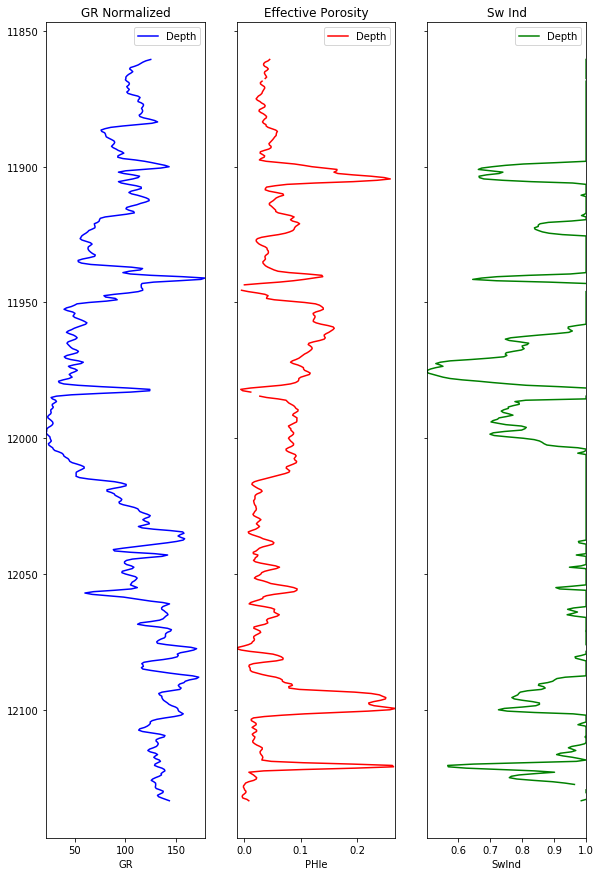

In [45]:
import matplotlib.pyplot as plt

dfplot=res[res['API']=='49037267870000']

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)


dfplot.plot(kind='line',x='GR', y='Depth', color='blue', title='GR Normalized',ax=axes[0],figsize=(4,15)).invert_yaxis()

dfplot.plot(kind='line',x='PHIe', y='Depth', color='red', title='Effective Porosity',ax=axes[1])

dfplot.plot(kind='line',x='SwInd', y='Depth', color='green',title='Sw Ind',ax=axes[2])
fig.subplots_adjust(right=2)

In [46]:
res

,Depth,API,GR,DEN,DPHI,NPHI,DeepResis,firstProductionDate,6MoOil,6MoGas,6MoBOE,12MoOil,12MoGas,12MoBOE,CumOil,CumGas,CumBOE,Sec,Township,Range,Elev,FrontierTopName,FrontierDepth,DakotaTopName,DakotaDepth,LON,LAT,DeepestGR,FrontierBase,KFThicknses,PetZone,ResFlag,cleanSandGR,shaleGR,ShaleRt,GRnorm,Vsh,DPHIc,NPHIc,PHIe,SwInd
22045,11122.5,49023222790000,108.185,2.548,0.06166,0.17003,7.481,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,True,True,39.039,180.657,6.704494,69.060571,0.488257,0.042130,0.072379,0.057254,1.000000
22046,11123.0,49023222790000,104.573,2.528,0.07396,0.16886,7.400,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,True,True,39.039,180.657,6.704494,67.020153,0.462752,0.055450,0.076310,0.065880,0.989593
22047,11123.5,49023222790000,102.901,2.520,0.07858,0.16937,7.383,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,True,True,39.039,180.657,6.704494,66.075640,0.450946,0.060542,0.079181,0.069862,0.981801
22048,11124.0,49023222790000,104.731,2.509,0.08517,0.17574,7.349,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,True,True,39.039,180.657,6.704494,67.109407,0.463868,0.066615,0.082966,0.074791,0.943293
22049,11124.5,49023222790000,108.439,2.508,0.08579,0.18030,7.342,2008-06-01,355.0,112720.0,19141.666667,652.0,244529.0,41406.833333,3009.0,1254193.0,212041.166667,28.0,20.0,112.0,6392,FRONTIER,11122.0,DAKOTA,11900.0,-110.06567,41.68014,12162.5,11422.0,300.0,True,True,39.039,180.657,6.704494,69.204056,0.490051,0.066188,0.082290,0.074239,0.919888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716019,12100.5,49041214610000,120.602,2.586,0.05600,0.13700,12.767,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,True,True,27.851,228.432,7.421817,66.992936,0.462412,0.037504,0.044518,0.041011,0.914842
716020,12101.0,49041214610000,128.106,2.595,0.05100,0.14000,11.004,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,True,True,27.851,228.432,7.421817,69.985841,0.499823,0.031007,0.040035,0.035521,0.976423
716021,12101.5,49041214610000,136.265,2.599,0.04800,0.14900,9.364,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,True,True,27.851,228.432,7.421817,73.239988,0.540500,0.026380,0.040900,0.033640,1.000000
716022,12102.0,49041214610000,138.794,2.597,0.05000,0.15600,8.716,2012-06-01,443.0,113049.0,19284.500000,690.0,178253.0,30398.833333,2410.0,626150.0,106768.333333,33.0,18.0,112.0,6497,SECOND FRONTIER BENCH,11803.0,DAKOTA TOP,12416.0,-110.06733,41.50237,12697.5,12103.0,300.0,True,True,27.851,228.432,7.421817,74.248658,0.553108,0.027876,0.045378,0.036627,1.000000


- Figure above. Normalized gamma ray, effective porosity, and water saturation for a well (API= 49037267870000) in the study. 


<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Study correlation of production and SgPhiH, calculated with different combinations of cutoff values 
</p><br>

- Below is the code that will calculate SgPhiH for all the wells in the study with lots of different cutoffs. 
- For example, below I am running 
    - GR from 0 to 150 at increments of 5
    - Porosity from 2 to 20%, increments of 2%
    - Hydrocarbon saturation (1-Sw) from 20 to 100%, in increments of 10%
- The code will run SgPhiH values for every single combination of those values
    - For example, there are 29 gr values, 10 porosity values, and 9 Sh values being tested, which means there are 29 times 10 times 9 (or 2,610) combinations being tested
- It will then find the correlation for each SgPhiH with each production metric (cum, 6, 12 mo)
- The result is a table with one row for each unique set of cutoff combinations, three R values (for each production metric), and a "wells represented" count which we'll disucss more later

In [11]:
# Study correlation of SgPhiH and Production Data for a variety of cutoffs

import copy

res['SgPhiIncremental'] = (1-res['SwInd'])*(res['PHIe'])*(0.5)  # Calculate SgPhiH at each depth

onelineR = res.groupby('API').max() # Create the dataframe to hold all of the correlation data

#CUTOFF RANGES
#GR
grMin=0
grMax=140
grInt=5

#Porosity
pMin=0.02
pMax=0.2
pInt=0.02

#Hydrocarbon Saturation
shMin=0.2
shMax=1
shInt=0.1

#Define arrays for loop
gr = np.arange(grMin, grMax+grInt, grInt)
por = np.arange(pMin, pMax+pInt, pInt)
sh = np.arange(shMin, shMax+shInt, shInt)

#Calculate number of rows for R df: 
nrows=len(gr)*len(por)*len(sh)

#rdf=pd.DataFrame(index=np.arange(nrows), columns=np.arange(4))

rdf=pd.DataFrame()

rBestcum = 0
rBest12Mo = 0
rBest6Mo = 0
for g in gr: 
    for p in por: 
        for s in sh: 
            onelineR['SgPhiH']= res[ (res['GR'] < g)
                           & (res['PHIe'] > p)
                           & ((1-res['SwInd']) >= s)].groupby('API').sum()['SgPhiIncremental']
            
            wellsRepresented=pd.notna(onelineR.SgPhiH).sum()
            rCumBOE=onelineR['SgPhiH'].corr(onelineR['CumBOE'])
            r12Mo=onelineR['SgPhiH'].corr(onelineR['12MoBOE'])
            r6Mo=onelineR['SgPhiH'].corr(onelineR['6MoBOE'])
#             if rCumBOE>rBestcum:
#                 rBestcum=rCumBOE
#                 dfCumBOE=
            
            x=[[g,p,s,rCumBOE, r12Mo, r6Mo,wellsRepresented]]
            rdf=rdf.append(x)
            
rdf = rdf.rename(columns={0: 'GRCutoff',1:'PorCutoff', 2:'ShCutoff', 3:'RcumBOE',4: 'R12MoBOE',5:'R6MoBOE',6:'WellsRepresented'})  
rdf=rdf.reset_index(drop=True)

KeyError: 'SwInd'

In [10]:
rdf

NameError: name 'rdf' is not defined

 - The above table is the collection of all cutoff combos and how SgPhiH for those cutoff combo's correlated to production (cum, 12, or 6 month). 
 - Below, we see every combination of cutoffs that did not produce an R value. I.e., these are cufoff combinations that were so restrictive that either 0 or 1 wells meet the criteria. Since you need 2 wells at minimum to have an R, these have null R values.
  

In [32]:
rdf[(pd.isna(rdf.RcumBOE))&(pd.isna(rdf.R6MoBOE))&(pd.isna(rdf.R12MoBOE))]

,GRCutoff,PorCutoff,ShCutoff,RcumBOE,R12MoBOE,R6MoBOE,WellsRepresented
0,0,0.02,0.2,NaN,NaN,NaN,0
1,0,0.02,0.3,NaN,NaN,NaN,0
2,0,0.02,0.4,NaN,NaN,NaN,0
3,0,0.02,0.5,NaN,NaN,NaN,0
4,0,0.02,0.6,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
2591,140,0.16,1.0,NaN,NaN,NaN,0
2599,140,0.18,0.9,NaN,NaN,NaN,0
2600,140,0.18,1.0,NaN,NaN,NaN,0
2608,140,0.20,0.9,NaN,NaN,NaN,0


In [33]:
rdf[(pd.isna(rdf.RcumBOE))&(pd.isna(rdf.R6MoBOE))&(pd.isna(rdf.R12MoBOE))].describe()

,GRCutoff,PorCutoff,ShCutoff,RcumBOE,R12MoBOE,R6MoBOE,WellsRepresented
count,1198.000000,1198.000000,1198.000000,0.0,0.0,0.0,1198.000000
mean,47.508347,0.114324,0.760434,NaN,NaN,NaN,0.124374
std,39.715334,0.058803,0.237757,NaN,NaN,NaN,0.330146
min,0.000000,0.020000,0.200000,NaN,NaN,NaN,0.000000
25%,15.000000,0.060000,0.600000,NaN,NaN,NaN,0.000000
50%,40.000000,0.120000,0.800000,NaN,NaN,NaN,0.000000
75%,75.000000,0.160000,0.900000,NaN,NaN,NaN,0.000000
max,140.000000,0.200000,1.000000,NaN,NaN,NaN,1.000000


 - The table above is a statistics summary table of all the rows which had cutoff combinations that yielded 0 or 1 wells.
 - Out of the 2610 rows of correlation data from the cutoffs in this example, 1198 (46%) had 0 to 1 wells and no R value.
 - I have found the more iterations I test over a wider range of values, the higher the percent cutoff combinations with no R value
 - At a glance, it appears that a high hydrocarbon saturation cutoff is the primary driver of cutoff combo's having 0 to 1 wells and no R value.
     - One question is whether one of the variables is contributing more to the null R combo's than others
     - The next three figures look at this in more detail - the are bin=10 histograms for the three cutoffs for the R=null dataset.

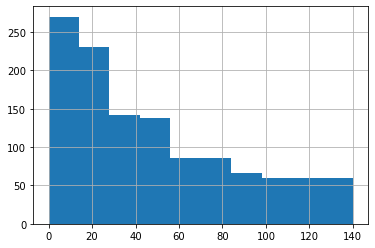

In [34]:
grNullHist = rdf[pd.isna(rdf.RcumBOE)].GRCutoff.hist(bins=10)

- Null R values occur more frequently at lower GR values. As you increase GR, you generally decrease the likelihood of having a null R value. 
- The trend appears to level off around GR=100...?

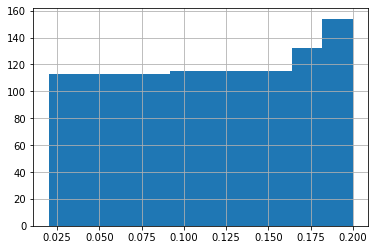

In [35]:
porNullHist = rdf[pd.isna(rdf.RcumBOE)].PorCutoff.hist(bins=10)

 - Porosity seems to control whether R will be null much less
 - Only once you start requiring your wells to have ~16% or greater do you start to see increased porosity cutoffs contribute to an increase in R=null values

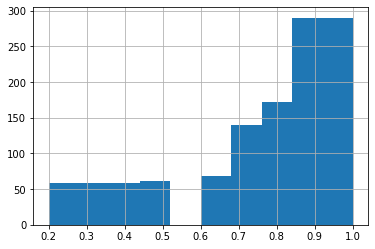

In [36]:
ShNullHist = rdf[pd.isna(rdf.RcumBOE)].ShCutoff.hist(bins=10)

- Between hydrocarbon saturation values of 20 to ~70%, Sh doesn't seem to correlate to trends in R=null
- Once you start looking at ~70% and above, there is a strong correlation that as Sh cutoff increases so does the frequency of R=null values
    -This makes sense - you're demanding a lot of your reservoir at that point, and many wells will not meet this criteria
- Not quite sure why there's a gap at ~0.5-0.6...

In [37]:
rdf[(rdf.RcumBOE>0)&(rdf.R6MoBOE>0)&(rdf.R12MoBOE>0)].describe()

,GRCutoff,PorCutoff,ShCutoff,RcumBOE,R12MoBOE,R6MoBOE,WellsRepresented
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,71.612903,0.089791,0.459583,0.407135,0.432576,0.427504,16.333966
std,27.274099,0.049405,0.189100,0.296933,0.299164,0.317864,9.483548
min,25.000000,0.020000,0.200000,0.002639,0.003713,0.000677,2.000000
25%,50.000000,0.040000,0.300000,0.226306,0.234468,0.191972,7.000000
50%,70.000000,0.080000,0.400000,0.280345,0.341809,0.347286,19.000000
75%,90.000000,0.120000,0.600000,0.510019,0.532644,0.600549,26.000000
max,140.000000,0.200000,0.800000,1.000000,1.000000,1.000000,28.000000


- The above table is another statistical summary, this time of all the rows in which R for any production metric was above zero. 
- For all the visualizations that follow, it would be a bit overwhelming to have all the visualizations I want to cover, times three for the three different production metrics (cums, 6, 12 months). 
 - Thus, I want to pick one production metric to move forward with for the following figures.
 - I am goign to somewhat arbitrarily use 12 Month Cums, although I think the figures would all look farily similar. 
 - The mean for non-zero R's was highest, slightly, for R12MoBOE, so we will use that for the following figures. 

In [1]:
#Visualization for GRnorm, PHIe, and Sw for a given well

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

from bokeh.layouts import gridplot

y=rdf.R12MoBOE

cutoffs12MoBOE = figure()

plot_options = dict(width=250, plot_height=250, tools='pan,wheel_zoom')

# create a new plot
s1 = figure(**plot_options, title='GR Cutoff')
s1.circle(rdf.GRCutoff, y, size=10, color="navy")

# create a new plot 
s2 = figure(y_range=s1.y_range, **plot_options,title='Porosity Cutoff')
s2.triangle(rdf.PorCutoff, y, size=10, color="firebrick")

# create a new plot
s3 = figure(y_range=s1.y_range,**plot_options,title='Hydrocarbon Saturation Cutoff')
s3.square(rdf.ShCutoff, y, size=10, color="olive")

s1.xaxis.axis_label = "GR >= Value"
s2.xaxis.axis_label = "Por >= Value"
s3.xaxis.axis_label = "Sh >= Value"
s1.yaxis.axis_label = "R with 12 Month BOE"


cutoffs12MoBOE = gridplot([[s1, s2, s3]])

show(cutoffs12MoBOE) 

Loading BokehJS ...

NameError: name 'rdf' is not defined

https://nbviewer.jupyter.org/github/AllieJackson/RMAG-Project/blob/master/RMAGDraft1.ipynb - The above figures show different cutoffs and the resultant R for 12 month BOE. 
 - Again, each datapoint was generated from SgPhiH values for each well with the specific set of cutoffs, and then those SgPhiH data for all 28 wells were compared to the production metrics for each of those wells.
 - Notice that there are some wells with "perfect" correlations
    - This can be explained with this concept: depending on how "restrictive" the combination of cutoff values was, not every well might have an SgPhiH value
    - For example, if one of the cutoff runs required GR <=30, but only 10 wells in the dataset had at least one half foot increment of GR<= 30, then only 10 wells would be represented for that particular cutoff combination. 
    - Similarly, as we prehttps://nbviewer.jupyter.org/github/AllieJackson/RMAG-Project/blob/master/RMAGDraft1.ipynbviously discussed, cutoff combos with 0-1 wells represented do not have an R value
    - And finally, the cutoff combinations which happened to produce 2 wells with data, then, have a "perfect" correlation as two points of course define a line.
    - This observation made me go back into my correlation code, and add a column that would track how many wells were represented for each SgPhiH (and then, R) count
    - We will see this below.

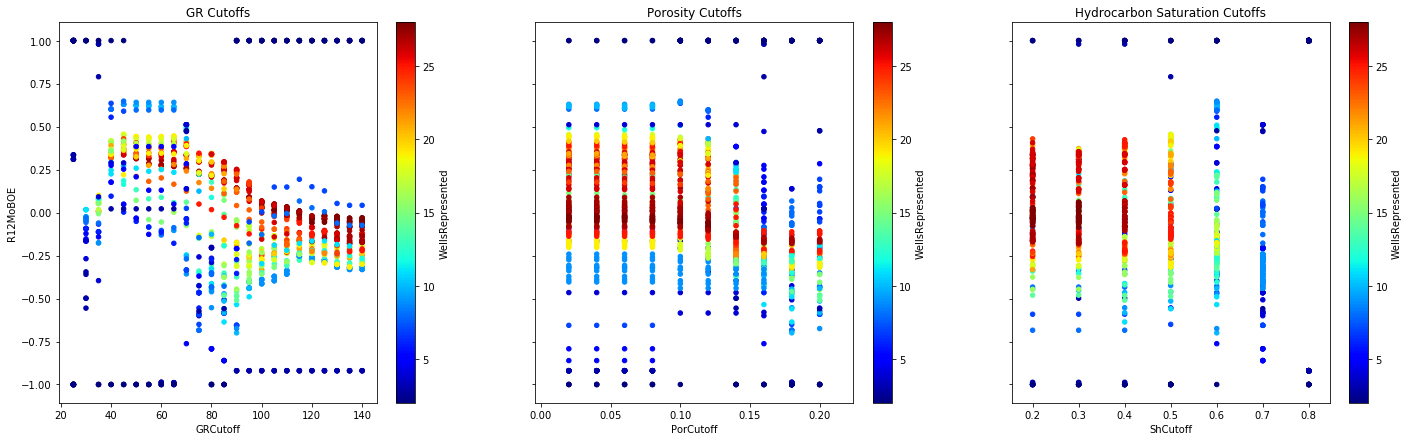

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)

#ax.set_ylim(1,-1)

rdf.plot(kind='scatter',x='GRCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='GR Cutoffs',ax=axes[0],figsize=(10,7), sharey=True)

rdf.plot(kind='scatter',x='PorCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='Porosity Cutoffs',ax=axes[1])

rdf.plot(kind='scatter',x='ShCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='Hydrocarbon Saturation Cutoffs',ax=axes[2])
fig.subplots_adjust(right=2)

The visualizations above (Cutoffs values vs. R's) should look similar to the three plots immediately above these. They are the exact same, but have been color-coded to reflect how many wells' worth of SgPhiH data went into each R value. 
    - Not surprisingly, the perfect correlations, either positive or negative, have low well counts. 
    - This begs the question of what percent of wells represented out of the entire dataset should be the minimum? 
    - The "hotter" colors, then, are more reliable as they represent more wells
- GR:
    - For GR, of the hotter colors, notice the best correlations are for cutoffs in the 40-60 range; above that they drop off until there are essentially not correlated even slightly around 100.
- Porosity:
    - Between 0 and ~13%, porosity continues to appear not to have a very big control on any of this. 
    - Above 13% our amout of values with a reiable well count ("hot colors") drops off, and is essentially absent above 15%.
- Hydrocarbon Saturation: 
    - As we saw with our R=null look in the begining, Sh values much above 60% are too restrictive for wells in this dataset
    - Also interesting, Sh seems to behave more as an on-off switch. It doesn't fade out as Por or GR; the "hot" colors simply stop above 50%.

Below: 
- The same three visualizations as the previous ones, but with well count restricted to well counts of at least 20.

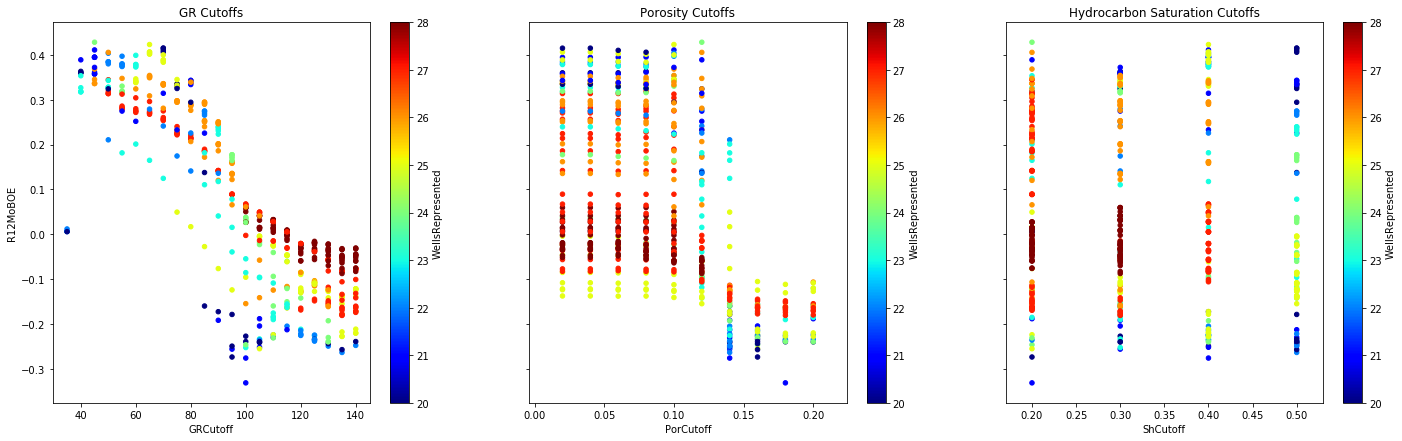

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3)

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='GRCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='GR Cutoffs',ax=axes[0],figsize=(10,7), sharey=True)

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='PorCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='Porosity Cutoffs',ax=axes[1])

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='ShCutoff', y='R12MoBOE', c='WellsRepresented',colormap='jet', title='Hydrocarbon Saturation Cutoffs',ax=axes[2])
fig.subplots_adjust(right=2)

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
What is the deal with all the negative R's? 
</p><br>

- Given that the three cutoff plots wrt R can obviously only plot one cutoff at a time, the question is whether the negative R values for each cutoff correspond to cutoff combos with wonkey values for one or both of the other cutoffs? 
- I think the figures below give a resounding "yes" to the above question.
- The plots below look at the three cutoffs (gr, por, and sh), and are then colorcoded by the other two cutoffs
    -E.g., GR colored by Por and then by Sh; Por colored by GR and then by Sh, etc.
- I think these figures do confirm that the majority of the negative R values in this dataset are explained by these cutoff combinations simply being "unreasonable." 
     - For example, the first row looks at the GR cutoff data. On the left it is color coded by the porosity cutoff used, and the right by the Sh cutoff used. 
         - The Sh cutoff does not seem to show any correlation to Gr cutoffs with respect to the correlation with SgPhiH
         - However, the higher porosity cutoff values are completely concentrated in the negative R value region of the plot
         - This makes perfect sense, because the negative R values are essentially coming from shales which we are requiring to have 20% porosity values - not reasonable/logical.
     - I believe the same can be seen with the Porosity cutoff charts (middle row)
         - The negative R's are mostly concentrated with the high GR values - also unreasonable as discussed above
         - Again, Sh seems to be totally randomly distributed here
     - Finally, similarly, on the third row looking at Sh, the negative R's tend to come when "extreme" values are required for GR or Por. 

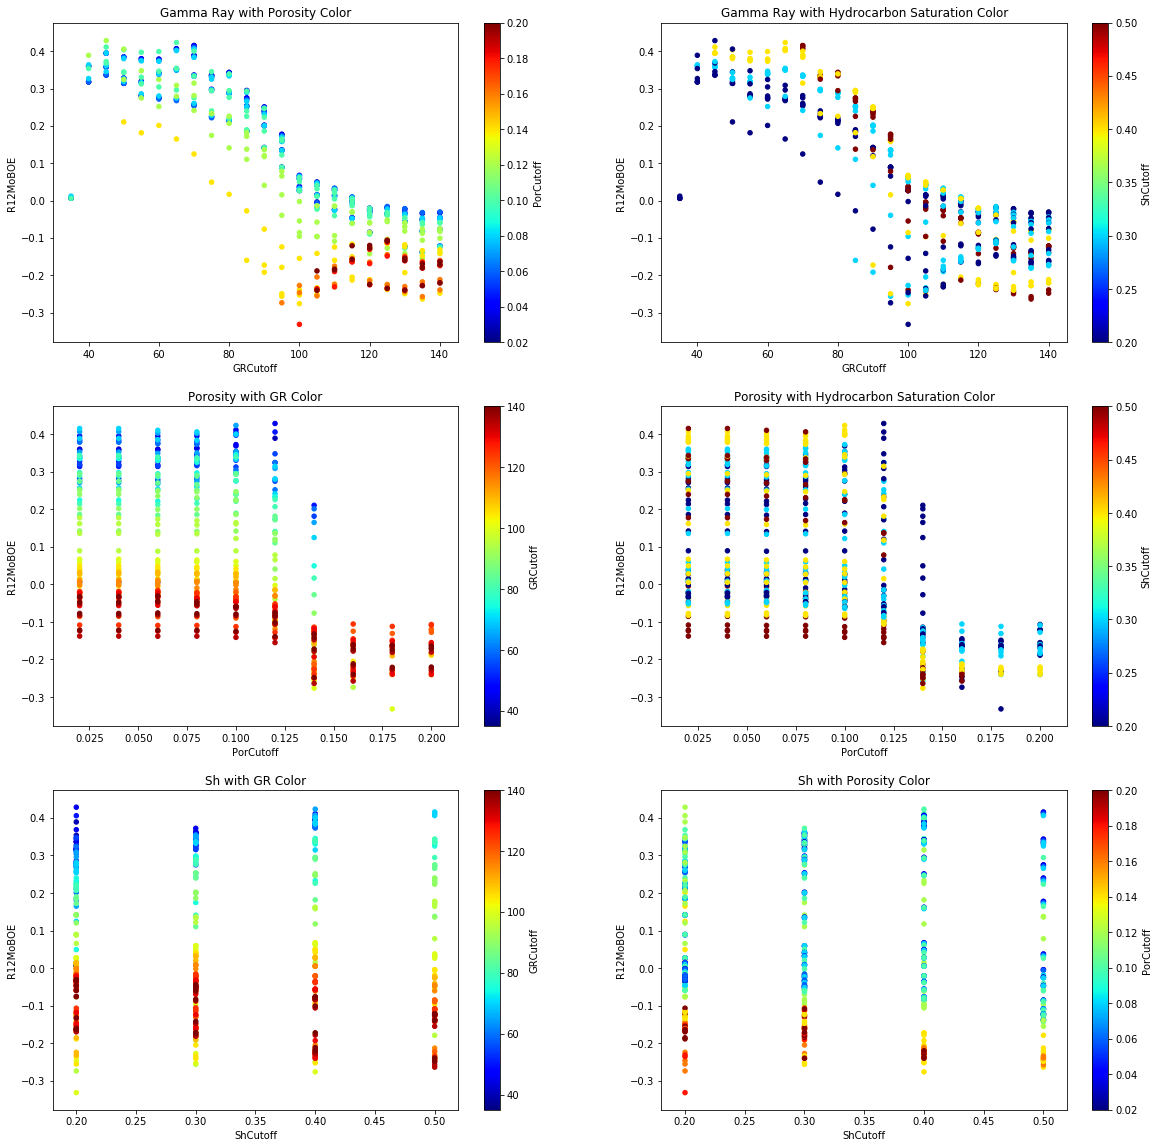

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2)

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='GRCutoff', y='R12MoBOE', c='PorCutoff',colormap='jet', title='Gamma Ray with Porosity Color',ax=axes[0,0],figsize=(15,15))
rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='GRCutoff', y='R12MoBOE', c='ShCutoff',colormap='jet', title='Gamma Ray with Hydrocarbon Saturation Color',ax=axes[0,1])

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='PorCutoff', y='R12MoBOE', c='GRCutoff',colormap='jet', title='Porosity with GR Color',ax=axes[1,0],figsize=(20,20))
rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='PorCutoff', y='R12MoBOE', c='ShCutoff',colormap='jet', title='Porosity with Hydrocarbon Saturation Color',ax=axes[1,1])

rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='ShCutoff', y='R12MoBOE', c='GRCutoff',colormap='jet', title='Sh with GR Color',ax=axes[2,0],figsize=(20,20))
rdf[rdf.WellsRepresented>=20].plot(kind='scatter',x='ShCutoff', y='R12MoBOE', c='PorCutoff',colormap='jet', title='Sh with Porosity Color',ax=axes[2,1])

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Concluding Remarks
</p></br>

___
The primary challenges in correlation with this dataset (i.e., overall low R values) are: 
- The age of the wells. A lot of this field - for more recent development - is controlled by depletion. It's a very old field and is therefore not free from depletion effects. Wells drilled recently (e.g., those in this dataset) will have production that does not strictly reflect the geology but rather is also impacted by depletion - a complicated function of distance to existing wells, drainage patterns and orientation, and fracure networks.
- Lack of EUR (Estimated Ultimate Recover) values. Certainly, using cumulative production, especially for relatively recent wells, is quite inferior to EUR values.
- Another potentially important factor impacting well performance in this field is the existance of highly variable natural fracure locations & patterns (e.g., Dutton, 1992).
___
Despite the overall low R values, we have accomplishsed the goal we set out to achieve with this workflow. We: 
- Successfully found, formatted, cleaned, and merged data from many different sources for analysis
- Created and applied an appropriate and sensical petrophysical model to the dataset
- Devised code to 
    - automatically calculate our reservoir characterization method of choice (hydrocabon saturated pore volume) based on the range of input values we specified for each input variable (GR, PHIe, and Water Saturation)
    - track correlation of all SgPhiH values (and their respective cutoffs) and three different production metrics 
- Obtained useful information about the absolute upper and lower bounds cutoff choices for each of our input variables by analyzing the R=0 dataset
- Achieved our primary goal of devising code that allows calculating reservoir metrics with a systematic and large number of input parameters in a fraction of the amount of time it would take using any more traditional methods. 
    - In this way, not only does the user save time, but can also test a much wider range of input parameters, potentially gaining greater insight to their reservoir's character
    

<p style="font-family: Arial; font-size:2em; font-style:bold"><br>
Future Work? 
</p><br>

- Assessing and addressing whether any of the variables discussed are correlated
- Finding and automating an improved 6 and 12 month cummulative production calculation method
    - Improving the "start point"
- Potentially attempting an automated EUR calculation for the production data

